In [2]:
trimport pandas as pd
from pandas.plotting import autocorrelation_plot
from pandas import DataFrame
from pandas import concat
import numpy as np
from math import sqrt

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats import boxcox

import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from matplotlib import colors
%matplotlib inline

import warningstr
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
col_names = ["Date/Time", "KW"]
df = pd.read_csv("01E002218541_20210101_20211231.csv")
df = df.rename({'Meter ID         ': 'Meter_ID', 'Date / Time           ': 'Date&Time', 'KW(ch: 1  set:1)    ': 'KW', 'KVA(ch: 2  set:1)   ': 'KVA', 'PF(1(ch: 2  set:1)  ':'PF'}, axis='columns')
df = df[['Date&Time','KW']]
df

,Date&Time,KW
0,1/1/21 00:15,91.36
1,1/1/21 00:30,85.04
2,1/1/21 00:45,87.52
3,1/1/21 01:00,87.28
4,1/1/21 01:15,89.12
...,...,...
35035,12/31/21 23:00,99.84
35036,12/31/21 23:15,89.20
35037,12/31/21 23:30,90.08
35038,12/31/21 23:45,87.44


In [10]:
col_names = ["Date/Time", "KW"]
df = pd.read_csv("01E002218541_20210101_20211231.csv")
df = df.rename({'Meter ID         ': 'Meter_ID', 'Date / Time           ': 'Date&Time', 'KW(ch: 1  set:1)    ': 'KW', 'KVA(ch: 2  set:1)   ': 'KVA', 'PF(1(ch: 2  set:1)  ':'PF'}, axis='columns')
df = df[['Date&Time','KW']]
df['Date&Time'] = df['Date&Time'].apply(lambda x: x.strip())
df['Date&Time'] = pd.to_datetime(df['Date&Time'],infer_datetime_format=True)
#df['Date&Time'] = pd.to_datetime(df['Date&Time']).dt.to_period('D')

In [11]:
df = df.set_index(['Date&Time'])
df.head()

,KW
Date&Time,
2021-01-01 00:15:00,91.36
2021-01-01 00:30:00,85.04
2021-01-01 00:45:00,87.52
2021-01-01 01:00:00,87.28
2021-01-01 01:15:00,89.12


In [12]:
df

,KW
Date&Time,
2021-01-01 00:15:00,91.36
2021-01-01 00:30:00,85.04
2021-01-01 00:45:00,87.52
2021-01-01 01:00:00,87.28
2021-01-01 01:15:00,89.12
...,...
2021-12-31 23:00:00,99.84
2021-12-31 23:15:00,89.20
2021-12-31 23:30:00,90.08



The first thing to do in any data analysis task is to plot the data. Graphs enable many features of the data to be visualised, including patterns, unusual observations, changes over time, and relationships between variables. The features that are seen in plots of the data must then be incorporated, as much as possible, into the forecasting methods to be used. 

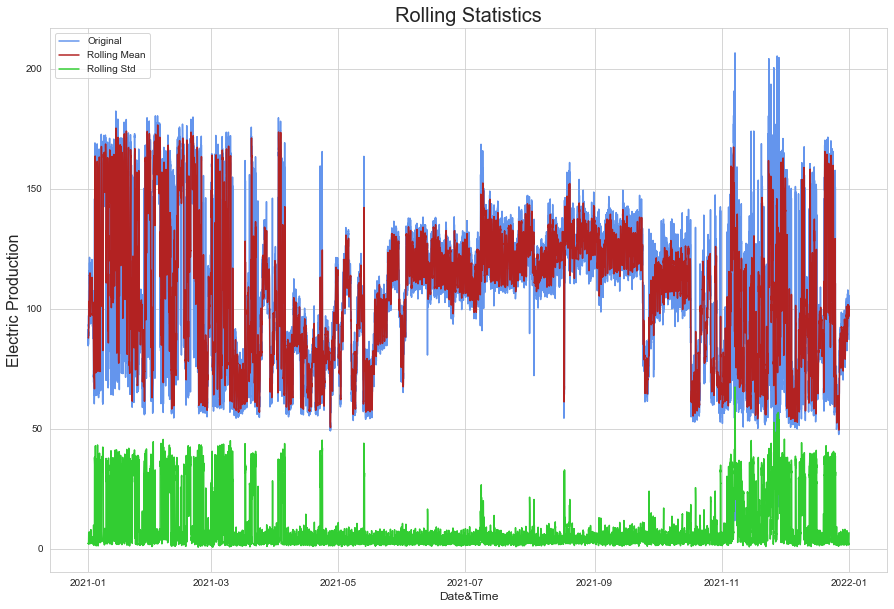

In [13]:
rolling_mean = df.rolling(window=12).mean()
rolling_std = df.rolling(window=12).std()
plt.figure(figsize = (15,10))
plt.plot(df, color='cornflowerblue', label='Original')
plt.plot(rolling_mean, color='firebrick', label='Rolling Mean')
plt.plot(rolling_std, color='limegreen', label='Rolling Std')
plt.xlabel('Date&Time', size = 12)
plt.ylabel('Electric Production', size  = 16)
plt.legend(loc = 'upper left')
plt.title('Rolling Statistics', size = 20)
plt.show()

"Checking Stationarity"

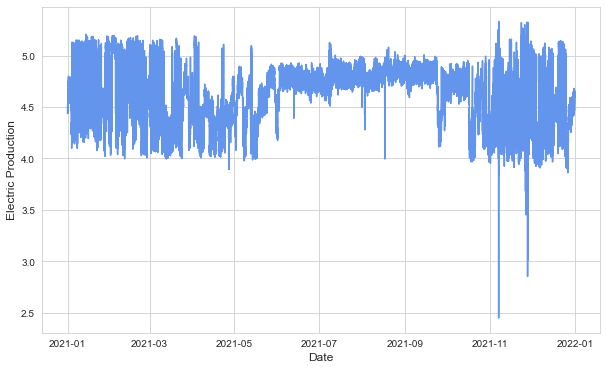

In [52]:
plt.figure(figsize = (10,6))
plt.plot(df['KW'], color = 'cornflowerblue')
plt.xlabel('Date', size = 12)
plt.ylabel('Electric Production', size = 12)
plt.show()

Looking at the plot we can observe there is an **upward trend** over the period of time.

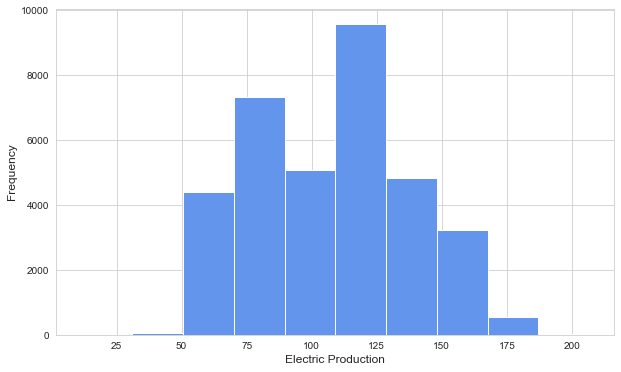

In [15]:
plt.figure(figsize = (10,6))
plt.hist(df['KW'], color = 'cornflowerblue')
plt.xlabel('Electric Production', size = 12)
plt.ylabel('Frequency', size = 12)
plt.show()

In [16]:
print("Data Shape: {}".format(df.shape))
value_1 = df[0:17520]
value_2 = df[17521:]

Data Shape: (35040, 1)


We will proceed by splitting the data into two parts so that we can then check the **mean** and **variance** of the data.

"Mean of Data"

In [17]:
print("Mean of value_1: {}".format(round(value_1.mean()[0],3)))
print("Mean of value_2: {}".format(round(value_2.mean()[0],3)))

Mean of value_1: 106.239
Mean of value_2: 108.926


"Variance"

In [18]:
print("Variance of value_1: {}".format(round(value_1.var()[0],3)))
print("Variance of value_2: {}".format(round(value_2.var()[0],3)))

Variance of value_1: 1071.884
Variance of value_2: 742.893


"Augmented Dickey-Fuller Test"

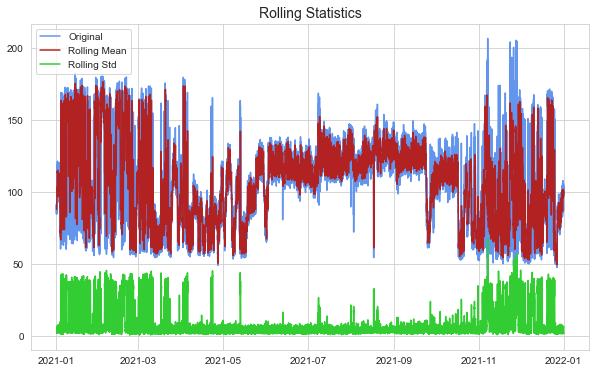

ADF Statistic: -11.311
p-value: 0.0
##################################
Critical Values:
1%: -3.431
5%: -2.862
10%: -2.567
##################################
ADF < Critical Values
Reject null hypothesis, time series is stationary.


In [19]:
def adfuller_test(ts, window = 12):
    
    movingAverage = ts.rolling(window).mean()
    movingSTD = ts.rolling(window).std()
    
    plt.figure(figsize = (10,6))
    orig = plt.plot(ts, color='cornflowerblue',
                    label='Original')
    mean = plt.plot(movingAverage, color='firebrick',
                    label='Rolling Mean')
    std = plt.plot(movingSTD, color='limegreen',
                   label='Rolling Std')
    plt.legend(loc = 'upper left')
    plt.title('Rolling Statistics', size = 14)
    plt.show(block=False)
    
    adf = adfuller(ts, autolag='AIC')
    
    print('ADF Statistic: {}'.format(round(adf[0],3)))
    print('p-value: {}'.format(round(adf[1],3)))
    print("##################################")  
    print('Critical Values:')
    
    for key, ts in adf[4].items():
         print('{}: {}'.format(key, round(ts,3)))
    print("##################################")
    
    if adf[0] > adf[4]["5%"]:
        print("ADF > Critical Values")
        print ("Failed to reject null hypothesis, time series is non-stationary.")
    else:
        print("ADF < Critical Values")
        print ("Reject null hypothesis, time series is stationary.")
        
adfuller_test(df, window = 12)

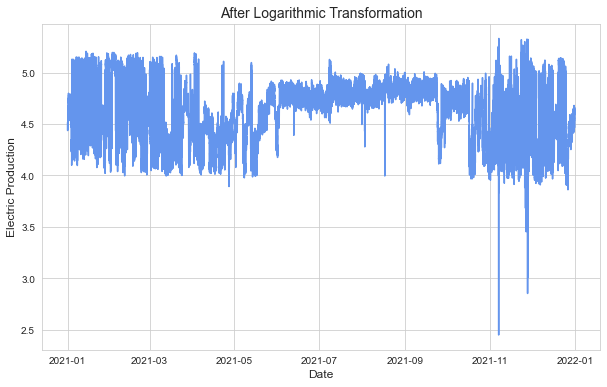

In [20]:
df_log_scaled = df
df_log_scaled['KW'] = boxcox(df_log_scaled['KW'], lmbda=0.0)
plt.figure(figsize = (10,6))
plt.plot(df_log_scaled, color = 'cornflowerblue')
plt.xlabel('Date', size = 12)
plt.ylabel('Electric Production', size = 12)
plt.title("After Logarithmic Transformation", size = 14)
plt.show()

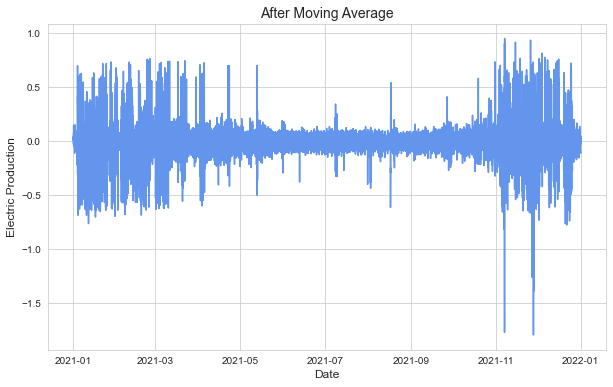

In [21]:
moving_avg = df_log_scaled.rolling(window=12).mean()
df_log_scaled_ma = df_log_scaled - moving_avg
df_log_scaled_ma.dropna(inplace=True)
plt.figure(figsize = (10,6))
plt.plot(df_log_scaled_ma, color = 'cornflowerblue')
plt.xlabel('Date', size = 12)
plt.ylabel('Electric Production', size = 12)
plt.title("After Moving Average", size = 14)
plt.show()

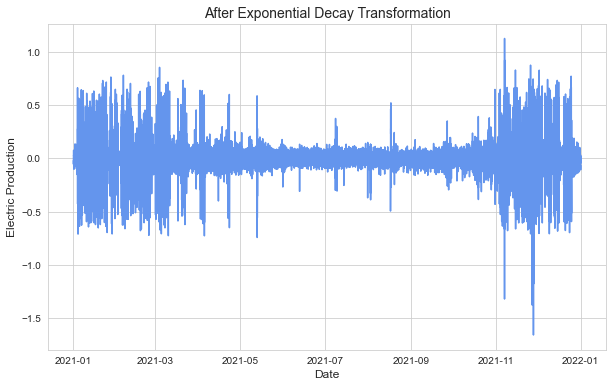

In [22]:
df_log_scaled_ma_ed = df_log_scaled_ma.ewm(halflife=12, min_periods=0, adjust=True).mean()
df_lsma_sub_df_lsma_ed = df_log_scaled_ma - df_log_scaled_ma_ed
plt.figure(figsize = (10,6))
plt.plot(df_lsma_sub_df_lsma_ed - df_log_scaled_ma_ed, color='cornflowerblue')
plt.xlabel('Date', size = 12)
plt.ylabel('Electric Production', size = 12)
plt.title("After Exponential Decay Transformation", size = 14)
plt.show()

In [27]:
df_lsma_sub_df_lsma_ed

,KW
Date&Time,
2021-01-01 03:00:00,0.000000
2021-01-01 03:15:00,0.009055
2021-01-01 03:30:00,-0.001609
2021-01-01 03:45:00,-0.040868
2021-01-01 04:00:00,-0.036586
...,...
2021-12-31 23:00:00,-0.013836
2021-12-31 23:15:00,-0.110874
2021-12-31 23:30:00,-0.085487


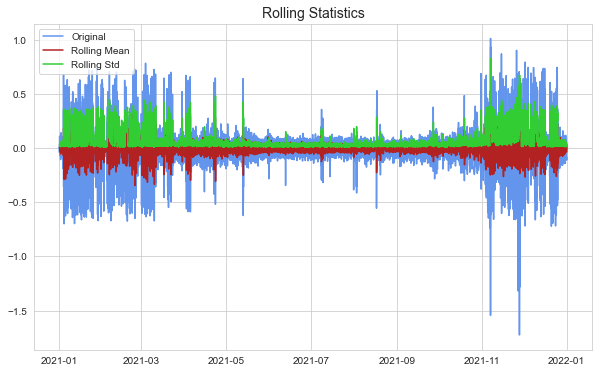

ADF Statistic: -37.589
p-value: 0.0
##################################
Critical Values:
1%: -3.431
5%: -2.862
10%: -2.567
##################################
ADF < Critical Values
Reject null hypothesis, time series is stationary.


In [28]:
adfuller_test(df_lsma_sub_df_lsma_ed, window = 12)

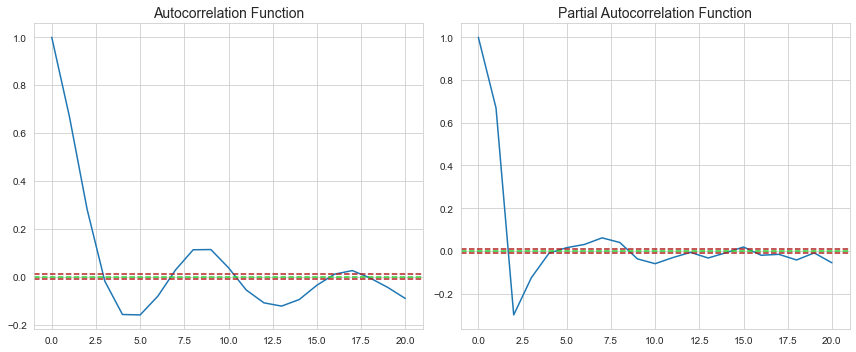

In [30]:
auto_c_f = acf(df_lsma_sub_df_lsma_ed, nlags=20)
partial_auto_c_f = pacf(df_lsma_sub_df_lsma_ed, nlags=20, method='ols')

fig, axs = plt.subplots(1, 2, figsize =(12,5))

plt.subplot(121)
plt.plot(auto_c_f)
plt.axhline(y=0, linestyle='--', color='limegreen')
plt.axhline(y=-1.96/np.sqrt(len(df_lsma_sub_df_lsma_ed)),
            linestyle='--', color='firebrick')
plt.axhline(y=1.96/np.sqrt(len(df_lsma_sub_df_lsma_ed)),
            linestyle='--', color='firebrick')
plt.title('Autocorrelation Function', size = 14)            

plt.subplot(122)
plt.plot(partial_auto_c_f)
plt.axhline(y=0, linestyle='--', color='limegreen')
plt.axhline(y=-1.96/np.sqrt(len(df_lsma_sub_df_lsma_ed)),
            linestyle='--', color='firebrick')
plt.axhline(y=1.96/np.sqrt(len(df_lsma_sub_df_lsma_ed)),
            linestyle='--', color='firebrick')
plt.title('Partial Autocorrelation Function', size = 14)
            
plt.tight_layout() 

In [31]:
values = DataFrame(df_lsma_sub_df_lsma_ed.values)
persistence_df = concat([values.shift(1), values], axis=1)
persistence_df.columns = ['t-1', 't+1']
per_values = persistence_df.values

train = per_values[1:len(per_values)-10] 
test = per_values[len(per_values)-10:]

X_train, y_train = train[:,0], train[:,1]
X_test, y_test = test[:,0], test[:,1]

def persistence(x):
    return x

predictions = []
for i in X_test:
    y_pred = persistence(i)
    predictions.append(y_pred)

persistence_score = mean_squared_error(y_test, predictions)
print('Persistence MSE: {}'.format(round(persistence_score,4)))

Persistence MSE: 0.0014


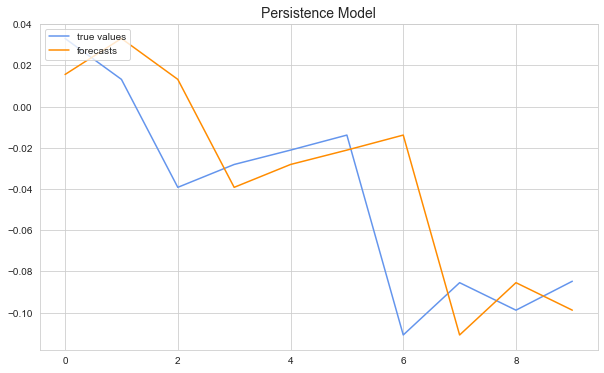

In [32]:
plt.figure(figsize = (10,6))
plt.plot(y_test, label = "true values", color = "cornflowerblue")
plt.plot(predictions,label = "forecasts", color='darkorange')
plt.title("Persistence Model", size = 14)
plt.legend(loc = 'upper left')
plt.show()

In [45]:
ar_values = df_lsma_sub_df_lsma_ed.values
train = ar_values[1:len(ar_values)-10] 
test = ar_values[len(ar_values)-10:]
model = ARIMA(train, order=(3,1,0))
AR_model = model.fit()

predictions = AR_model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
ar_score = mean_squared_error(test, predictions)
print('AR MSE: {}'.format(round(ar_score,4)))

AR MSE: 0.0051


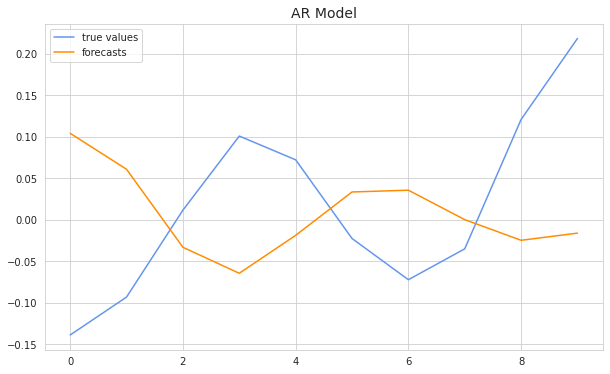

In [19]:
plt.figure(figsize = (10,6))
plt.plot(test, label = "true values", color = "cornflowerblue")
plt.plot(predictions,label = "forecasts", color='darkorange')
plt.title("AR Model", size = 14)
plt.legend(loc = 'upper left')
plt.show()

In [46]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train, order=(5,1,0))
MA_model = model.fit()

predictions = MA_model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
ma_score = mean_squared_error(test, predictions)
print('MA MSE: {}'.format(round(ma_score,4)))

MA MSE: 0.0049


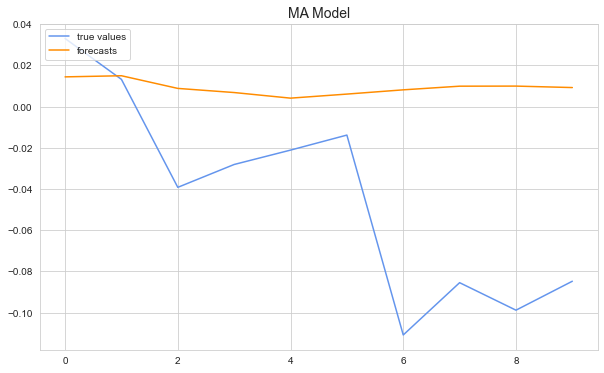

In [47]:
plt.figure(figsize = (10,6))
plt.plot(test, label = "true values", color = "cornflowerblue")
plt.plot(predictions,label = "forecasts", color='darkorange')
plt.title("MA Model", size = 14)
plt.legend(loc = 'upper left')
plt.show()

In [48]:
model = ARIMA(train, order=(2,1,2))
ARIMA_model = model.fit()

predictions = ARIMA_model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
arima_score = mean_squared_error(test, predictions)
print('ARIMA MSE: {}'.format(round(arima_score,4)))

ARIMA MSE: 0.0054


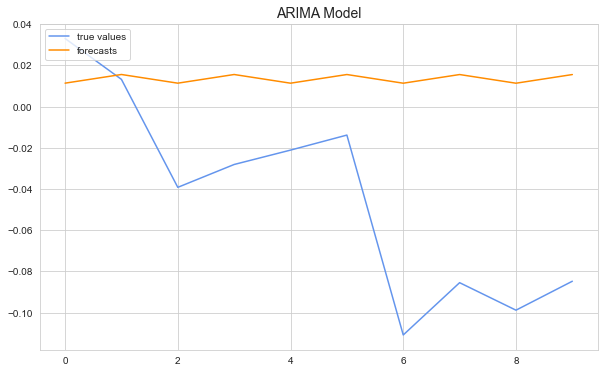

In [49]:
plt.figure(figsize = (10,6))
plt.plot(test, label = "true values", color = "cornflowerblue")
plt.plot(predictions,label = "forecasts", color='darkorange')
plt.title("ARIMA Model", size = 14)
plt.legend(loc = 'upper left')
plt.show()

In [50]:
errors = pd.DataFrame()
errors["Model"] = ["Persistence", "Autoregression", "Moving Average", "ARIMA"]
errors["MSE"] = [persistence_score, ar_score, ma_score, arima_score]
errors = errors.sort_values("MSE", ascending = True, ignore_index = True)
errors.index = errors.Model
del errors["Model"]

def coloring_bg(s, min_, max_, cmap='Reds', low=0, high=0):
    color_range = max_ - min_
    norm = colors.Normalize(min_ - (color_range * low), max_ + (color_range * high))
    normed = norm(s.values)
    c = [colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
    return ['background-color: %s' % color for color in c]

errors.style.apply(coloring_bg,min_ =errors.min().min(),
               max_ = errors.max().max(), low = 0.1, high = 0.85)

,MSE
Model,
Persistence,0.001411
Moving Average,0.004884
Autoregression,0.005078
ARIMA,0.005421
